In [1]:
import numpy as np
from rebin import rebin #pip install rebin
import matplotlib.pyplot as plt
import random
import h5py
from libsx import *
import pickle

np.random.seed = 42

In [2]:
nGasPower = 13

In [3]:
# filename of output file to be created
#foutbase = "SIC_"                                                     
#foutsuffix = ".dat"
#fout = foutbase + str(nGasPower).zfill(3) + foutsuffix

In [4]:
grav_const_in_cgs = G = 6.6738e-8
MSun = 1.98892e33

In [5]:
Ngas = 2**round(nGasPower)                      # The number of gas particles in the simulation

In [6]:
Mgas = MSun                                     # The mass of the cloud
rgas = 9.2e16  #!!!!!!!!!!!!!!!!!!!!!!!!        # The initial radius of the cloud in cm

Beta = 0.01 # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
omega_0 = (3.*Beta*G*Mgas/rgas**3)**0.5
print(f'omega_0 = {omega_0:.2E}')

omega = omega_0                                 # The initial angular velocity of the cloud in radians s^-1 
rho0 = 6.02e-19 #!!!!!!!!!!!!!!!!!!!!!!!!       # The initial average density
#cs = 1.9e4                                     # The sound speed

mH = 1.6726e-24 # gram
kB = 1.3807e-16  # cm2 g s-2 K-1
T_0 = 10. # K,  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Note that for pure molecular hydrogen mu=2. For molecular gas with ~10% He by mass and trace metals, mu ~ 2.7 is often used.
muu = 2.28 # !!!!!!!!!! Gives c_s = 1.9e4
mH2 = muu * mH

alpha = 5./2.*rgas*kB*T_0/G/Mgas/muu/mH
print('alpha = ', round(alpha, 3))

cs = (kB * T_0 / mH2)**0.5   # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

print('cs = ', round(cs, 2))


omega_0 = 7.15E-14
alpha =  0.627
cs =  19027.7


In [7]:
# Calculating derived quantities
tff = np.sqrt(3*np.pi/(32*G*rho0))                   # The free-fall time = 3.4e4 yr
tff_in_kyr = tff/3600/24/365.24/1000
print(f'tff in kyr = {tff_in_kyr:.2f}')

tff in kyr = 85.80


In [8]:
# Setting the units of the simulation
unitMass_in_g = MSun
unitLength_in_cm = rgas
unitTime_in_s = (unitLength_in_cm**3/grav_const_in_cgs/unitMass_in_g)**0.5
unitVelocity_in_cm_per_s = unitLength_in_cm / unitTime_in_s

In [9]:
print(f'Unit_time_in_s = {round(unitTime_in_s, 2)} seconds')
print(f'Unit_time in kyrs = {round(unitTime_in_s/3600./24./365.25/1000., 2)} kyrs')
print(f'Unit_time in Myrs = {round(unitTime_in_s/3600./24./365.25/1e6, 4)} Myrs')

Unit_time_in_s = 2422068880502.64 seconds
Unit_time in kyrs = 76.75 kyrs
Unit_time in Myrs = 0.0768 Myrs


In [10]:
print(f'unitVelocity_in_cm_per_s = {round(unitVelocity_in_cm_per_s, 2)} cm/s')

unitVelocity_in_cm_per_s = 37984.06 cm/s


In [11]:
# calling things to code units
rgas /= unitLength_in_cm
Mgas /= unitMass_in_g
omega *= unitTime_in_s

In [12]:
UnitDensity_in_cgs = unitMass_in_g / unitLength_in_cm**3
print(f'UnitDensity_in_cgs = {UnitDensity_in_cgs:.2E}')

UnitDensity_in_cgs = 2.55E-18


In [13]:
# Making a uniform grid of particles from which I will carve a sphere
# with Ngas particles.

regular_grid = False

if regular_grid:
    ninds = max((15,2*round(((1.1*Ngas)*3./4/np.pi)**.333333333)))              # Size of grid template
    
    inds = np.arange(ninds)-np.floor(ninds/2)
    
    zarr, yarr, xarr = np.mgrid[inds[0]:inds[-1]:ninds+0j, inds[0]:inds[-1]:ninds+0j, inds[0]:inds[-1]:ninds+0j]
    
    gridInds=np.array(range(len(xarr)))
    
    xarr = xarr.flatten().reshape(1, -1)
    yarr = yarr.flatten().reshape(1, -1)
    zarr = zarr.flatten().reshape(1, -1)

    pos = np.transpose(np.concatenate([xarr, yarr, zarr]))

    rarr = (pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)**0.5       # vector of distance from origin to grid points 
    
    nsrt = (np.argsort(rarr))[:Ngas-1]  # Indices for Ngas points closest to origin (carving sphere !!!)
    rsrt = rarr[nsrt]
    
    if max(rsrt) > ninds/2:
        print('Must increase ninds!') # You're trying to simulate a cloud with a very large number of particles.
                                      # Increase ninds if you want this error to go away.
    
    pos = pos[nsrt, :] # Position of particles in sphere
    
    pos *= rgas/max(rsrt)  #Scaling particle positions to where I want them to be in the simulation
    
    r = (pos[:,0]**2 + pos[:,1]**2 + pos[:,2]**2)**0.5

else:
    
    r = np.random.random(Ngas)*rgas
    u = np.random.random(Ngas)*2 - 1
    theta = np.random.random(Ngas)*2*np.pi

    xt = (r**(1./3.) * (1. - u**2)**0.5 * np.cos(theta)).reshape(1, -1)
    yt = (r**(1./3.) * (1. - u**2)**0.5 * np.sin(theta)).reshape(1, -1)
    zt = (r**(1./3.) * u).reshape(1, -1)

    pos = np.transpose(np.concatenate([xt, yt, zt]))
    # Shouldn't we also normalize this one !!!!!??????



## Calculating particle velocities in rectangular coordinates

In [14]:
rxy = (pos[:,0]**2 + pos[:,1]**2)**0.5
vel = np.zeros_like(pos)

print(vel.shape, pos.shape, r.shape)

vel[:,0] = -r*omega*pos[:,1]/rxy * rxy/r    # r * omega * cos(theta) * sin(phi)
vel[:,1] = r*omega*pos[:,0]/rxy * rxy/r     # r * omega * sin(theta) * sin(phi)
vel[:,2] = 0                                # theta is angle with respec to the z axis, phi is the azimuthal angle

wh = np.argwhere(np.isnan(vel))
if len(wh) > 0:
    vel[wh] = 0.0


(8192, 3) (8192, 3) (8192,)


## Calculating particle masses

In [15]:
mp = Mgas / pos.shape[0]

# Imposing an m=2 density perturbation with an amplitude of 10 percent.
#masses = mp * (1 + .1*((pos[:, 0]/rxy)**2 - (pos[:, 1]/rxy)**2))
masses = mp * np.ones(pos.shape[0])
#boxsize = rgas/unitLength_in_cm

wh = np.argwhere(np.isnan(masses)) # Fixes an issue with the particle at the origin
if len(wh) > 0:
    masses[wh] = mp

In [16]:
# Assign particle sound speed (isothermal EOS)
u = np.zeros(len(masses)) + cs**2 / unitVelocity_in_cm_per_s**2

## Create header

In [17]:
#write intial conditions file

ids = np.arange(pos.shape[0])

FloatType = np.float32  # double precision: np.float64, for single use np.float32
IntType = np.int32

IC = h5py.File('hfv_ic.hdf5', 'w')

## create hdf5 groups
header = IC.create_group("Header")
part0 = IC.create_group("PartType0")

## header entries
NumPart = np.array([pos.shape[0]], dtype=IntType)
header.attrs.create("NumPart_ThisFile", NumPart)
header.attrs.create("NumPart_Total", NumPart)
header.attrs.create("NumPart_Total_HighWord", np.zeros(1, dtype=IntType) )
header.attrs.create("MassTable", np.zeros(1, dtype=IntType) )
header.attrs.create("Time", 0.0)
header.attrs.create("Redshift", 0.0)
header.attrs.create("BoxSize", 0)
header.attrs.create("NumFilesPerSnapshot", 1)
header.attrs.create("Omega0", 0.0)
header.attrs.create("OmegaB", 0.0)
header.attrs.create("OmegaLambda", 0.0)
header.attrs.create("HubbleParam", 1.0)
header.attrs.create("Flag_Sfr", 0)
header.attrs.create("Flag_Cooling", 0)
header.attrs.create("Flag_StellarAge", 0)
header.attrs.create("Flag_Metals", 0)
header.attrs.create("Flag_Feedback", 0)
if pos.dtype == np.float64:
    header.attrs.create("Flag_DoublePrecision", 1)
else:
    header.attrs.create("Flag_DoublePrecision", 0)

## copy datasets
part0.create_dataset("Coordinates", data=pos)
part0.create_dataset("Velocities", data=vel)
part0.create_dataset("ParticleIDs", data=ids )
part0.create_dataset("Masses", data=masses)
part0.create_dataset("InternalEnergy", data=u)

IC.close()

In [18]:
pos.shape

(8192, 3)

In [19]:
print('Done !')

Done !


In [20]:
t = 2.0

np.cos(2.*t)

-0.6536436208636119

In [21]:
np.cos(t)**2 - np.sin(t)**2

-0.6536436208636119

In [22]:
h = do_smoothingX((pos, pos))

In [23]:
dictx = {'r': pos, 'v': vel, 'm': masses,
         'unitVelocity': unitVelocity_in_cm_per_s,
         'unitTime': unitTime_in_s,
         't_ff': tff}

num = str(int(np.floor(pos.shape[0]/1000)))

with open('hfv_IC_RND_' + num +'k_tmp.pkl', 'wb') as f:
    pickle.dump(dictx, f)

## Plot the particles

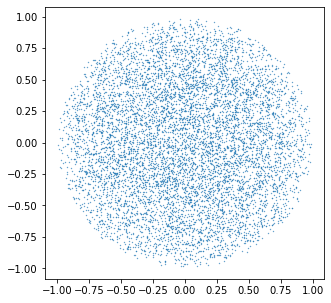

In [24]:
plt.figure(figsize = (5,5))
plt.scatter(pos[:, 0], pos[:, 1], s = 0.1);

## Density profile

In [25]:
#-------- rho ---------
rho = getDensity(pos, masses, h)

In [26]:
rr = (pos[:, 0]*pos[:, 0] + pos[:, 1]*pos[:, 1] + pos[:, 2]*pos[:, 2])**0.5

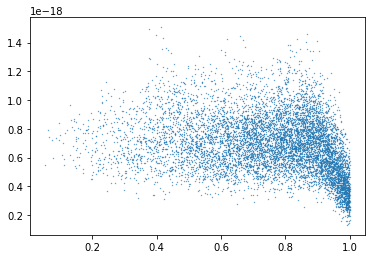

In [27]:
plt.scatter(rr, (rho)*UnitDensity_in_cgs, s = 0.1);

In [28]:
UnitDensity_in_cgs

2.55419372071998e-18